In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import gc
from collections import Counter
import copy

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

In [7]:
#读取数据
df_train = pd.read_csv(r'data_format1\train_format1.csv')
df_test = pd.read_csv(r'data_format1\test_format1.csv')

user_info = pd.read_csv(r'data_format1\user_info_format1.csv')
user_log = pd.read_csv(r'data_format1\user_log_format1.csv')

print(df_test.shape,df_train.shape)
print(user_info.shape,user_log.shape)

(261477, 3) (260864, 3)
(424170, 3) (54925330, 7)


In [8]:
#user_info 使用空值去替换
#user_info['age_range'].replace(0.0,np.nan,inplace=True)
#user_info['gender'].replace(2.0,np.nan,inplace=True)
#user_info.info()
user_info['age_range'] = user_info['age_range'].replace(0.0, np.nan)
user_info['gender'] = user_info['gender'].replace(2.0,np.nan)
user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  329039 non-null  float64
 2   gender     407308 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [9]:
#user_info使用-1替换空值
#user_info['age_range'].replace(np.nan,-1,inplace=True)
#user_info['gender'].replace(np.nan,-1,inplace=True)
user_info['age_range'] = user_info['age_range'].replace(np.nan, -1)  
user_info['gender'] = user_info['gender'].replace(np.nan, -1)

Text(0.5, 1.0, '用户年龄分布')

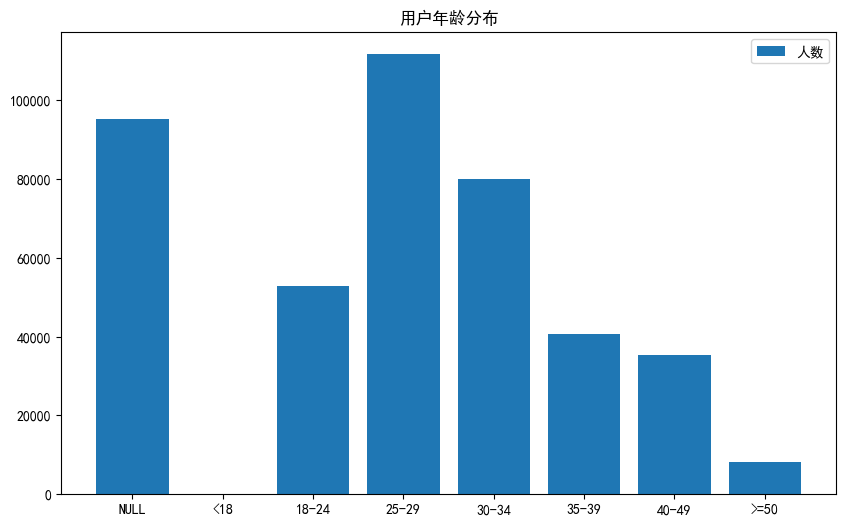

In [10]:
#年龄分布可视化
fig = plt.figure(figsize = (10,6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
y = np.array([user_info[user_info['age_range'] == -1]['age_range'].count(),
              user_info[user_info['age_range'] == 1]['age_range'].count(),
              user_info[user_info['age_range'] == 2]['age_range'].count(),
              user_info[user_info['age_range'] == 3]['age_range'].count(),
              user_info[user_info['age_range'] == 4]['age_range'].count(),
              user_info[user_info['age_range'] == 5]['age_range'].count(),
              user_info[user_info['age_range'] == 6]['age_range'].count(),
              user_info[user_info['age_range'] == 7]['age_range'].count()+
              user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='人数')
plt.legend()
plt.title('用户年龄分布')

Text(0.5, 1.0, '用户性别分布')

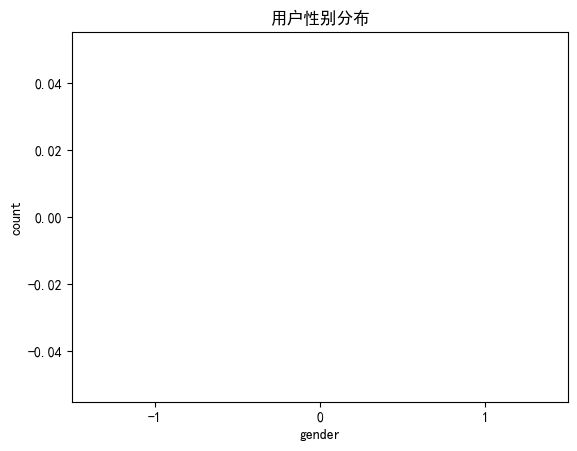

In [11]:
#用户性别分布可视化
sns.countplot(x = 'gender',order = [-1,0,1],data = user_info)
plt.title('用户性别分布')

Text(0.5, 1.0, '用户年龄—性别分布')

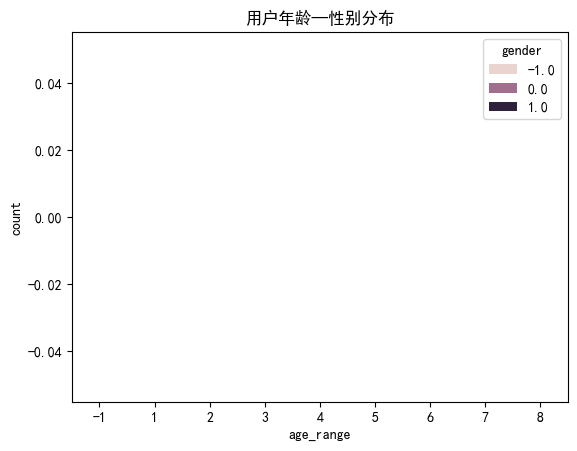

In [12]:
#用户年龄-性别分布
sns.countplot(x = 'age_range',order = [-1,1,2,3,4,5,6,7,8],hue = 'gender',data = user_info)
plt.title('用户年龄—性别分布')

In [14]:
#开始进行特征值合并
df_train = pd.merge(df_train,user_info,on="user_id",how="left")
 
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]])["item_id"].count().reset_index()
 
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_item_id"},inplace=True)
 
df_train = pd.merge(df_train,total_logs_temp,on=["user_id","merchant_id"],how="left")
 
unique_item_id = user_log.groupby(["user_id","seller_id","item_id"]).count().reset_index()[["user_id","seller_id","item_id"]]
 
unique_item_id_cnt = unique_item_id.groupby(["user_id","seller_id"]).count().reset_index()
 
unique_item_id_cnt.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_id"},inplace=True)
 
df_train = pd.merge(df_train, unique_item_id_cnt, on=["user_id", "merchant_id"], how="left")
 
cat_id_temp = user_log.groupby(["user_id", "seller_id", "cat_id"]).count().reset_index()[["user_id", "seller_id", "cat_id"]]
 
cat_id_temp_cnt = cat_id_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
cat_id_temp_cnt.rename(columns={"seller_id":"merchant_id","cat_id":"total_cat_id"},inplace=True)
 
df_train = pd.merge(df_train, cat_id_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
time_temp = user_log.groupby(["user_id", "seller_id", "time_stamp"]).count().reset_index()[["user_id", "seller_id", "time_stamp"]]
 
time_temp_cnt = time_temp.groupby(["user_id", "seller_id"]).count().reset_index()
 
time_temp_cnt.rename(columns={"seller_id":"merchant_id","time_stamp":"total_time_temp"},inplace=True)
 
df_train = pd.merge(df_train, time_temp_cnt, on=["user_id", "merchant_id"], how="left")
 
click_temp = user_log.groupby(["user_id", "seller_id", "action_type"])["item_id"].count().reset_index()
 
click_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)
 
click_temp["clicks"] = click_temp["action_type"] == 0
 
click_temp["clicks"] = click_temp["clicks"] * click_temp["times"]
 
click_temp["shopping_cart"] = click_temp["action_type"] == 1
click_temp["shopping_cart"] = click_temp["shopping_cart"] * click_temp["times"]
 
click_temp["purchases"] = click_temp["action_type"] == 2
click_temp["purchases"] = click_temp["purchases"] * click_temp["times"]
 
click_temp["favourites"] = click_temp["action_type"] == 3
click_temp["favourites"] = click_temp["favourites"] * click_temp["times"]
 
four_features = click_temp.groupby(["user_id", "merchant_id"]).sum().reset_index()
 
#删除相关列
four_features = four_features.drop(["action_type", "times"], axis=1)
 
#合并
df_train = pd.merge(df_train, four_features, on=["user_id", "merchant_id"], how="left")
 
#缺失值向前填充
df_train = df_train.ffill()
 

In [15]:
#将构建好的特征保存
df_train.to_csv("df_train.csv",index = None)

In [26]:
#读取数据
df_train = pd.read_csv(r"df_train.csv")
#加载最终测试数据
test_data = pd.read_csv(r"test_data.csv")
test_data

FileNotFoundError: [Errno 2] No such file or directory: 'test_data.csv'

In [ ]:
#模型构建

In [16]:
#建模预处理
y = df_train['label']
x = df_train.drop(["user_id","merchant_id","label"],axis = 1)
x.head(10)

,age_range_x,gender_x,total_item_id_x,unique_item_id_x,total_cat_id_x,total_time_temp_x,clicks_x,shopping_cart_x,purchases_x,favourites_x,age_range_y,gender_y,total_item_id_y,unique_item_id_y,total_cat_id_y,total_time_temp_y,clicks_y,shopping_cart_y,purchases_y,favourites_y
0,6.0,0.0,39,20,6,9,36,0,1,2,6.0,0.0,39,20,6,9,36,0,1,2
1,6.0,0.0,14,1,1,3,13,0,1,0,6.0,0.0,14,1,1,3,13,0,1,0
2,6.0,0.0,18,2,1,2,12,0,6,0,6.0,0.0,18,2,1,2,12,0,6,0
3,6.0,0.0,2,1,1,1,1,0,1,0,6.0,0.0,2,1,1,1,1,0,1,0
4,-1.0,0.0,8,1,1,3,7,0,1,0,-1.0,0.0,8,1,1,3,7,0,1,0
5,4.0,1.0,1,1,1,1,0,0,1,0,4.0,1.0,1,1,1,1,0,0,1,0
6,5.0,0.0,3,2,1,1,2,0,1,0,5.0,0.0,3,2,1,1,2,0,1,0
7,5.0,0.0,83,48,15,3,78,0,5,0,5.0,0.0,83,48,15,3,78,0,5,0
8,5.0,0.0,7,4,1,1,6,0,1,0,5.0,0.0,7,4,1,1,6,0,1,0
9,4.0,1.0,4,1,1,2,2,0,1,1,4.0,1.0,4,1,1,2,2,0,1,1


In [17]:
#分割数据
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 10)

In [21]:
#logistic回归
logit = LogisticRegression(solver = 'liblinear')
logit.fit(x_train,y_train)
predict = logit.predict(x_test)
print(predict[0:20]) #打印前20个预测结果
predict_proba = logit.predict_proba(x_test)
print(predict_proba[:]) #打印所有预测结果
score = accuracy_score(y_test,predict)
score #打印准确率

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.80075147 0.19924853]
 [0.9548469  0.0451531 ]
 [0.95061674 0.04938326]
 ...
 [0.89900594 0.10099406]
 [0.9476469  0.0523531 ]
 [0.95393872 0.04606128]]


0.9386847603166388

In [25]:
#逻辑回归最终结果获取
logit_Ans_Predict_proba = logit.predict_proba(test_data)
df_test["proba"] = logit_Ans_predict_proba[:,1]
#最终答案保存
df_test.to_csv("Logit_Ans.csv",index = None)

NameError: name 'test_data' is not defined

In [24]:
#决策树
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 4,random_state = 0)
tree.fit(x_train,y_train)
predict_proba = tree.predict_proba(x_test)
print(predict_proba[:])
print("Accuracy on training set: {:.3f}".format(tree.score(x_train,y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(x_test,y_test)))

[[0.8962217  0.1037783 ]
 [0.95970617 0.04029383]
 [0.95970617 0.04029383]
 ...
 [0.8962217  0.1037783 ]
 [0.95970617 0.04029383]
 [0.95970617 0.04029383]]
Accuracy on training set: 0.939
Accuracy on test set: 0.939


In [ ]:
#决策树最终结果获取
Tree_Ans_Predict_proba = tree.predict_proba(test_data)
df_test["proba"] = Tree_Ans_Predict_proba[:,1]
#最终结果保存
df_test.to_csv("Tree_Ans.csv",index = None)